The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


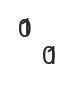

In [104]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance, BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset, MultimodalPepTCRDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

# quick annealing checks

In [113]:

class AbstractParent():
    def __init__(self, arg_a):
        self.arg_a = arg_a
        self.max_len_tcr = 1

    def slice_x(self, x):
        print(x)
        print(self.max_len_tcr)

class ChildClass(AbstractParent):
    def __init__(self, max_len_tcr):
        super(ChildClass, self).__init__(arg_a='nothing')
        self.max_len_tcr = max_len_tcr

instance = ChildClass(max_len_tcr=12)
instance.slice_x(x='test')


test
12


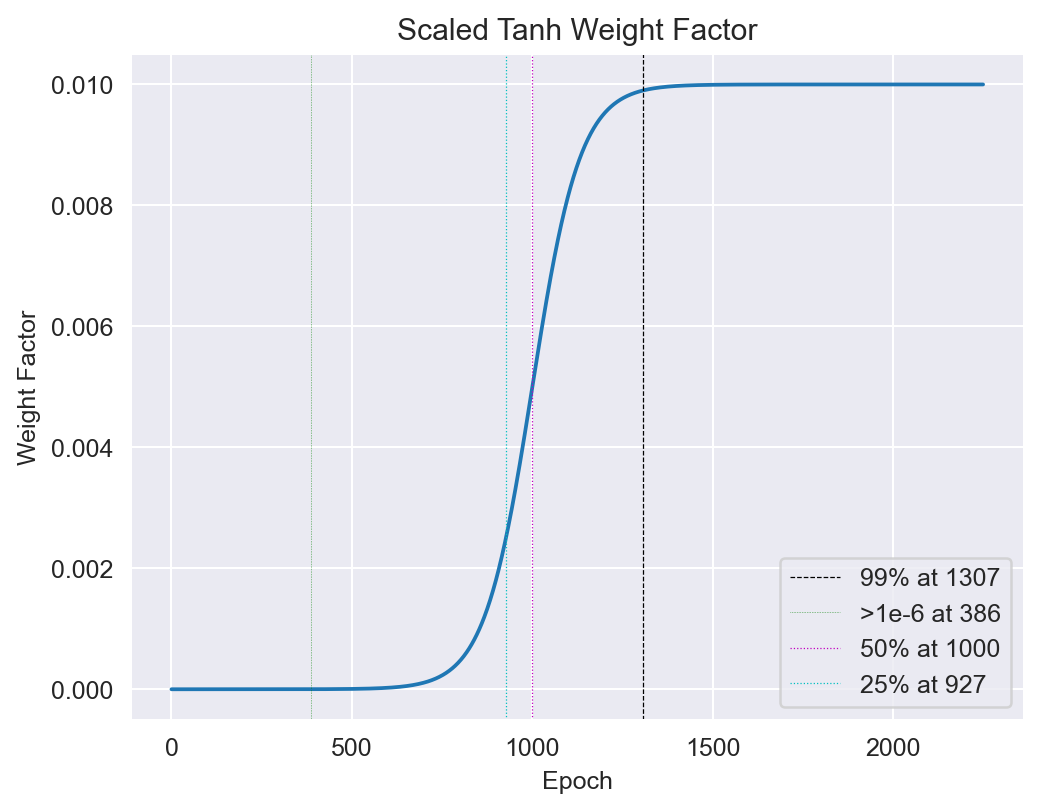

In [81]:
from src.utils import plot_tanh_annealing

plot_tanh_annealing(15000, 0.01, 0.0075, 1500)

In [83]:
n_epochs = 1500
for e in range(1, n_epochs+1):
    if (n_epochs >= 10 and e % math.ceil(0.1 * n_epochs) == 0) or e == 1 or e == n_epochs:
        print(e)


1
150
300
450
600
750
900
1050
1200
1350
1500


# BSSVAE with paired data

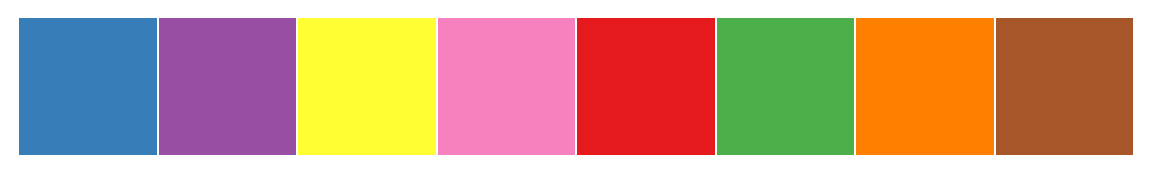

In [124]:
sns.palplot(get_palette('Set1', 8))

In [128]:
a = 1

c = 5
for b in range(10):
    print(b, a < b <= c)

0 False
1 False
2 True
3 True
4 True
5 True
6 False
7 False
8 False
9 False


tensor([0.0000e+00, 2.3779e-07, 2.4260e-07,  ..., 2.5000e-03, 2.5000e-03,
        2.5000e-03])


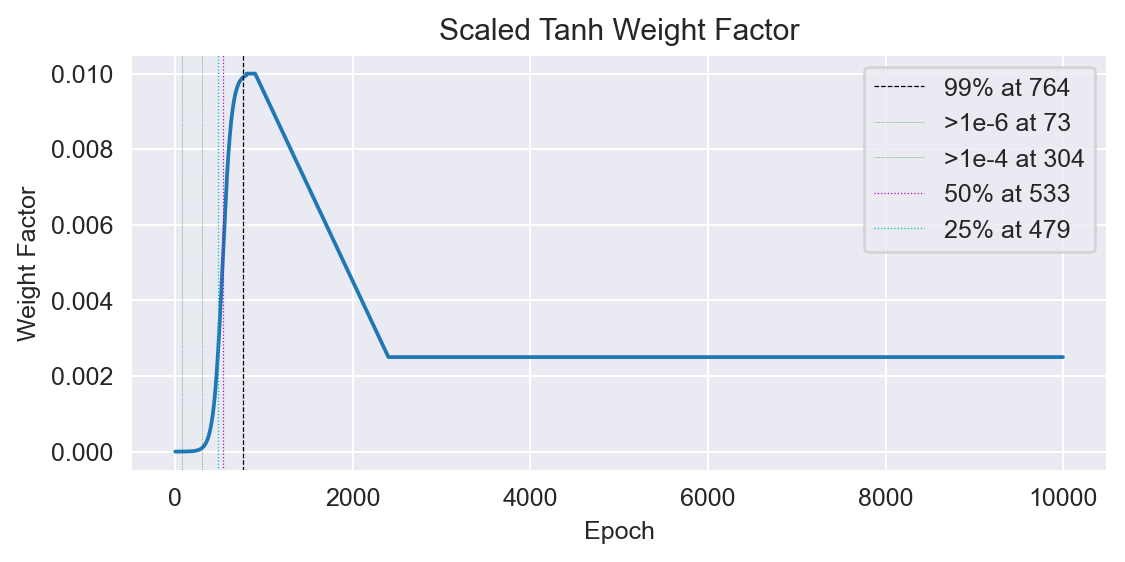

In [204]:
from src.multimodal_metrics import JMVAELoss, BSSVAELoss
from src.utils import plot_criterion_annealing
crit = BSSVAELoss(weight_kld_n = 1e-2, kld_warm_up = 800, kld_tanh_scale=0.01, flat_phase=100, kld_decrease=5e-4)
y = plot_criterion_annealing(10000, crit, 1)

In [153]:
base_weight = crit.base_weight_kld_n
p50 = torch.where((y < 0.5025 * base_weight) & (y > 0.4975 * base_weight))[0]
p50

tensor([466, 467])

# Re-loading models

In [205]:
multimodal_df = pd.read_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv')

In [206]:
preds = pd.read_csv('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/valid_predictions_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.csv')

In [208]:
cols=[x for x in preds.columns if not x.startswith('z_')]
preds[cols]

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db,seq_true,seq_recon,seq_acc,fold
0,XXXXXXXXX,TSGFNG,NVLDGL,AAADSNYQLI,MRHNA,SNTAGT,ASSRQGGTDTQY,NaN,NaN,NaN,0,tcr,immrep_negs,TSGFNGXNVLDGLXXAAADSNYQLIXXXXXXXXXXXXMRHNAXSNT...,SSGYNGXTMTNGGXXAVTNSNHKLMXXXXXXXXXXXXTSHNTXTTN...,0.377778,0
1,XXXXXXXXX,NSMFDY,ISSIKDK,AAAEFDAGNMLT,LGHDT,YNNKEL,ASSQETSGSLTDTQY,NaN,NaN,NaN,0,tcr,immrep_negs,NSMFDYXISSIKDKXAAAEFDAGNMLTXXXXXXXXXXLGHDTXYNN...,SSATSGXITSNSNPXAASTASSSSKLCXXXXXXXXXXTGHETXYTN...,0.313726,0
2,XXXXXXXXX,SSVPPY,YTSAATLV,AAAGGSYIPT,MNHEY,SVGAGI,ASSLATNEKLF,NaN,NaN,NaN,0,tcr,immrep_negs,SSVPPYXYTSAATLVAAAGGSYIPTXXXXXXXXXXXXMNHEYXSVG...,TSATNWXMTSSNEPXAMTSSSNKLVXXXXXXXXXXXXTNHNTXTTN...,0.260870,0
3,XXXXXXXXX,DSASNY,IRSNVGE,AAAKSYNTDKLI,SGHDY,FNNNVP,ASSYRQGAETQY,NaN,NaN,NaN,0,tcr,immrep_negs,DSASNYXIRSNVGEXAAAKSYNTDKLIXXXXXXXXXXSGHDYXFNN...,SSATSGXITSSSDGXAASAASSSNKLVXXXXXXXXXXTNHETXYTN...,0.312500,0
4,XXXXXXXXX,SVFSS,VVTGGEV,AAANQAGTALI,LGHDT,YNNKEL,ASSLAGGPYEQY,NaN,NaN,NaN,0,tcr,immrep_negs,SVFSSXXVVTGGEVXAAANQAGTALIXXXXXXXXXXXLGHDTXYNN...,NSATSGXIMSNAEPXAASASSSNKLTXXXXXXXXXXXTNHETXYTN...,0.326087,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7727,AVFDRKSDAK,NSASQS,VYSSG,VVNAGGGADGLT,MNHEY,SVGAGI,ASSYPGQPQH,HLA-A*11:01,1.0,NaN,0,tcr_pep,nettcr,NSASQSXVYSSGXXXVVNAGGGADGLTXXXXXXXXXXMNHEYXSVG...,NSATQGXVYSNGGXXAVSAASSSSKLVXXXXXXXXXXTNHSTXTHN...,0.523102,0
7728,AVFDRKSDAK,VSGLRG,LYSAGEE,AVHTDNDYKLS,MGHRA,YSYEKL,ASSQARGGYEQY,HLA-A*11:01,1.0,NaN,0,tcr_pep,nettcr,VSGLRGXLYSAGEEXAVHTDNDYKLSXXXXXXXXXXXMGHRAXYSY...,SSATSGXIYSNGEGXAATSSSSNKLTXXXXXXXXXXXTNHETXTTN...,0.550013,0
7729,LLWNGPMAV,NSASQS,VYSSG,VVFNFNKFY,KGHSH,LQKENI,ASSPDGGHSTDTQY,HLA-A*02:01,1.0,NaN,0,tcr_pep,nettcr,NSASQSXVYSSGXXXVVFNFNKFYXXXXXXXXXXXXXKGHSHXLQK...,NTATQGXVYSNGGXXAVSSSNKLLXXXXXXXXXXXXXTNHSTXATN...,0.438954,0
7730,RAKFKQLL,NSASDY,IRSNMDK,AENEVGSQGNLI,SGHTA,FQGTGA,ASSFYAGSTNEQF,HLA-B*08:01,1.0,NaN,0,tcr_pep,nettcr,NSASDYXIRSNMDKXAENEVGSQGNLIXXXXXXXXXXSGHTAXFQG...,NSATNWXITSNADPXAASSASASNKLVXXXXXXXXXXTGHNTXYHN...,1.156783,0


In [227]:
from src.metrics import get_acc_list_string
preds['seq_acc'] = get_acc_list_string(preds['seq_true'], preds['seq_recon'])

In [228]:
preds.groupby('input_type')['seq_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
input_type,,,,,,,,
pep,2750.0,0.054416,0.075780,0.000000,0.000000,0.000000,0.111111,0.500000
tcr,3021.0,0.302699,0.074343,0.046512,0.254545,0.300000,0.348837,0.585366
tcr_pep,1961.0,0.282336,0.081287,0.087719,0.228070,0.271186,0.327273,0.618182


In [111]:
# 3rd test can load best
# redo 1st test can load 2250

first_model = get_model('../output/BSSVAE_worked/BSSVAE_FirstTest_200nh_100nl_15kepochs_250wu_KFold_0_240318_1645_07Gc9A/', verbose=True, map_location='cpu')

third_model = get_model('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/', verbose=True, map_location='cpu')
third_model_last = load_model_full('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/epoch_13500_interval_checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
                                   '../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c_JSON_kwargs.json',
                                   map_location='cpu')

Reloading best model:
Best epoch: 994
Best val loss: 0.08882168347223993
total: 0.08882168347223993
recon_marg: 0.02913100861700623
recon_joint: 0.023316913937379485
kld_marg: 0.0008898978936070389
kld_joint: 0.03548386655007012
tcr_marg_seq_accuracy: 0.29168784618377686
tcr_joint_seq_accuracy: 0.31561216711997986
pep_joint_seq_accuracy: 0.2850262224674225
pep_marg_seq_accuracy: 0.0527159683406353
mean_seq_accuracy: 0.23626055102795362
Reloading best model:
Best epoch: 2360
Best val loss: 0.09844853986227531
total: 0.09844853986227531
recon_marg: 0.029187592968899397
recon_joint: 0.030139345347060652
kld_marg: 0.0010232108396756776
kld_joint: 0.03809838730239674
tcr_marg_seq_accuracy: 0.2907351553440094
tcr_joint_seq_accuracy: 0.3056580126285553
pep_joint_seq_accuracy: 0.16265100240707397
pep_marg_seq_accuracy: 0.05322333797812462
mean_seq_accuracy: 0.20306687708944082
Reloading best model:
epoch: 13500
total: 0.4343040112267338
recon_marg: 0.028617679920809297
recon_joint: 0.020017263

In [241]:
nn.Identity??

Init signature: nn.Identity(*args: Any, **kwargs: Any) -> None
Source:        
class Identity(Module):
    r"""A placeholder identity operator that is argument-insensitive.

    Args:
        args: any argument (unused)
        kwargs: any keyword argument (unused)

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Output: :math:`(*)`, same shape as the input.

    Examples::

        >>> m = nn.Identity(54, unused_argument1=0.1, unused_argument2=False)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 20])

    """
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__()

    def forward(self, input: Tensor) -> Tensor:
        return input
File:           ~/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/torch/nn/modules/linear.py
Type:           type
Subclasses:     

In [248]:
test = [nn.Linear(100, 50), nn.LeakyReLU(), nn.BatchNorm1d(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.BatchNorm1d(20)]
test.extend([nn.Linear(20, 10), nn.LeakyReLU(), nn.BatchNorm1d(10)])
test2 = [nn.Linear(100, 50), nn.LeakyReLU(), nn.Identity(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.Identity(20)]
m = nn.Sequential(*test)
m2 = nn.Sequential(*test2)
x = torch.rand((100,100))

m(x)

tensor([[ 2.3526e-01, -2.9895e-01, -4.7957e-01, -4.6173e-01, -1.7089e-01,
         -2.8655e-01, -7.5871e-01, -3.1143e-01, -1.8083e-01,  4.8768e-01],
        [-6.0486e-01,  9.0394e-02, -7.4524e-01,  1.7329e+00, -5.8739e-01,
         -6.5449e-01, -6.1739e-01,  5.8146e-01, -6.7050e-01,  1.0021e+00],
        [-5.9844e-01, -7.4348e-01,  1.1644e+00, -4.7539e-01, -5.9805e-01,
         -5.3622e-01,  1.2740e-01, -8.6661e-01, -2.0065e-01, -1.1648e-01],
        [-4.6469e-02, -1.7896e-01, -7.6181e-01, -4.6614e-01, -6.0121e-01,
         -6.5935e-01, -7.6692e-01, -8.5411e-01, -6.7428e-01, -6.8079e-01],
        [ 4.9365e-01,  2.2271e+00,  1.9602e-01, -2.8226e-01,  2.5921e+00,
          1.9314e+00, -7.5687e-01, -8.6291e-01,  2.2532e+00,  2.0262e+00],
        [ 1.0160e+00,  2.0001e+00,  2.4067e+00, -4.7975e-01,  2.8203e+00,
         -3.0646e-01, -8.1242e-01,  8.3680e-01,  3.6275e+00, -6.6315e-01],
        [ 7.9421e-01,  1.8090e+00, -7.5387e-01, -4.5517e-01, -5.9512e-01,
         -6.6357e-01, -7.6702e-0

In [239]:
zz=torch.load('../output/2403XX_multimodal/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
           map_location='cpu')
zz['best']

{'Best epoch': 2360,
 'total': 0.09844853986227531,
 'recon_marg': 0.029187592968899397,
 'recon_joint': 0.030139345347060652,
 'kld_marg': 0.0010232108396756776,
 'kld_joint': 0.03809838730239674,
 'tcr_marg_seq_accuracy': 0.2907351553440094,
 'tcr_joint_seq_accuracy': 0.3056580126285553,
 'pep_joint_seq_accuracy': 0.16265100240707397,
 'pep_marg_seq_accuracy': 0.05322333797812462,
 'mean_seq_accuracy': 0.20306687708944082}